In [22]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage.io import imsave
from torchvision.utils import save_image
import imageio
from PIL import Image
from skimage import data, color
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
import random
import zipfile
import cv2
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F
from scipy.ndimage import rotate, gaussian_filter 
from pathlib import Path
from numpy import sqrt

# Generar Fondos

In [3]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=(64, 64)):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Fix: converimos float [0,1] a uint8 [0,255]
    patches = (patches * 255).astype(np.uint8)

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [ ]:
# Tamaño de las imágenes de rostros
size = (64, 64)
print(f'Image size: {size}')

# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []

FACES_IMAGES = round(12833 / 2)

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
pictures_folder_path = 'pictures'
if not os.path.exists(pictures_folder_path):
    with zipfile.ZipFile('Pictures.zip', 'r') as zip_ref:
        zip_ref.extractall(pictures_folder_path)

for i in range(31):
    filename = f'{pictures_folder_path}/{str(i)}.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))


# print("Obteniendo imágenes de STL10 …")
# stl_tf = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     # opcional: CenterCrop(96) para estar seguro
# ])
# stl = datasets.STL10(root="./data", split="unlabeled", download=True)
# # 4 scales x 64 = 256 => TOTAL_IMAGES = (40 + max_stl_imgs) * 256 => max_stl_imgs = (TOTAL_IMAGES/256) - 40
# max_stl_imgs = round((TOTAL_IMAGES/256) - 40)
# added = 0
# for img_pil, _ in tqdm(stl):
#     img_np = np.array(stl_tf(img_pil), dtype=np.float32) / 255.0
#     images.append(img_np)
#     added += 1
#     # if added >= max_stl_imgs:
#     #     break

# print(f"Agregadas {added} imágenes de STL-10; total imágenes: {len(images)}")

# dtd_tf = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((100, 100))
# ])
# splits = ['train', 'val', 'test']
# added = 0
# for split in splits:
#     dtd = datasets.DTD(root='./data', split=split, download=True)
#     for img_pil, _ in tqdm(dtd, desc=f'DTD {split}', leave=False):
#         img_np = np.array(dtd_tf(img_pil), dtype=np.float32) / 255.0
#         images.append(img_np)
#         added += 1

# print(f"Agregadas {added} imágenes de DTD; total imágenes: {len(images)}")

# Transformación mínima ----------------------------------
#    (solo Gris + Resize 128×128 para tener margen)
final_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((150, 150), interpolation=Image.Resampling.LANCZOS),
])

# Detector rápido de rostros (OpenCV Haar) ---------------
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
# Detector de cuerpo completo:
body_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_fullbody.xml"
)
# Detector de perfil (rostros de lado):
profile_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_profileface.xml"
)
# Detector de parte superior del cuerpo:
upperbody_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_upperbody.xml"
)

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def contains_person(pil_img) -> bool:
    """True si la escena contiene rostro o persona."""
    # Trabajamos en 256×256 **BGR** (color) – cascadas vanilla aceptan BGR/GRAY
    img_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    # Haar rostros (frontal + perfil)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if len(face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(20,20))) > 0:
        return True
    if len(profile_cascade.detectMultiScale(gray, 1.1, 4, minSize=(20,20))) > 0:
        return True

    # Full body cascada (conda-forge la trae: haarcascade_fullbody.xml)
    if len(body_cascade.detectMultiScale(gray, 1.05, 4, minSize=(30,30))) > 0:
        return True
    if len(upperbody_cascade.detectMultiScale(gray, 1.05, 4, minSize=(30,30))) > 0:
        return True

    # HOG: duplicamos tamaño → cuerpos <64 px se vuelven >64 px
    big = cv2.resize(img_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    rects, _ = hog.detectMultiScale(
        big, winStride=(4,4), padding=(8,8), scale=1.02, groupThreshold=1
    )
    return len(rects) > 0

# Imagenes del dataset Places365 train-standard 
places = datasets.Places365(
    root="./data",
    split="val",          # 36 500 imágenes
    small=True,           # usa los tar de 256 px (ligeros)
    download=False
)

added = 0
# 5 scales x 64 = 320 => TOTAL_IMAGES = (40 + max_places_imgs) * 320 => max_places_imgs = (TOTAL_IMAGES/320) - 40
#max_places_imgs = round((TOTAL_IMAGES/320) - 40)
max_places_imgs = 500
print("Añadiendo imágenes de Places365 (filtrando personas)…")

for pil_img, _ in tqdm(places):
    if contains_person(pil_img):
        continue
    # pasa el filtro → convierte a gris+128 y normaliza a [0,1]
    img128 = np.array(final_tf(pil_img), dtype=np.float64) / 255.0
    images.append(img128)
    added += 1
    if added >= max_places_imgs:
        break

# Eliminar imágenes específicas
indexToRemove = [40,42,54,126,127,147,167,191,196,212,215,218,219,236,241,242,250,259,260,265,273,293,305,306,318,330,338,341,355,371,393,416,460,485]
for i in sorted(indexToRemove, reverse=True):
    if i < len(images):
        del images[i]

print(f"Imágenes de Places365 (sin personas): {added - len(indexToRemove)}")
print(f"Total de imágenes: {len(images)}")

Image size: (64, 64)
Añadiendo imágenes de Places365 (filtrando personas)…


  7%|▋         | 2476/36500 [04:03<55:43, 10.18it/s]  

Imágenes Places365 añadidas (sin personas): 500
Total de imágenes después de eliminar las específicas: 509


In [5]:
# Imprimir el tipo de dato de images
print(f'Type of images: {type(images)}')
print(f'Type of images[0]: {type(images[0])}')
print(f'{images[150].dtype=}, {images[150].min()=}, {images[150].max()=}')

Type of images: <class 'list'>
Type of images[0]: <class 'numpy.ndarray'>
images[150].dtype=dtype('float64'), images[150].min()=0.0, images[150].max()=0.9372549019607843


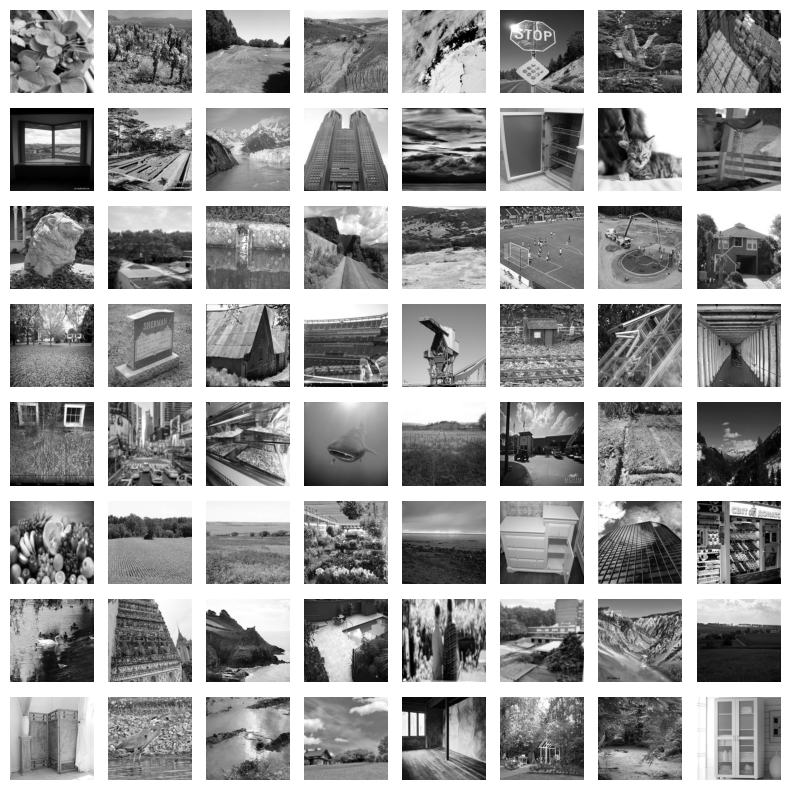

In [26]:
# Visualización
total_display = 64  # Número total de imágenes a mostrar
fig, ax = plt.subplots(round(sqrt(total_display)), round(sqrt(total_display)), figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

random_images = random.sample(images, total_display)
for i in range(total_display):
    axes[i].imshow(random_images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

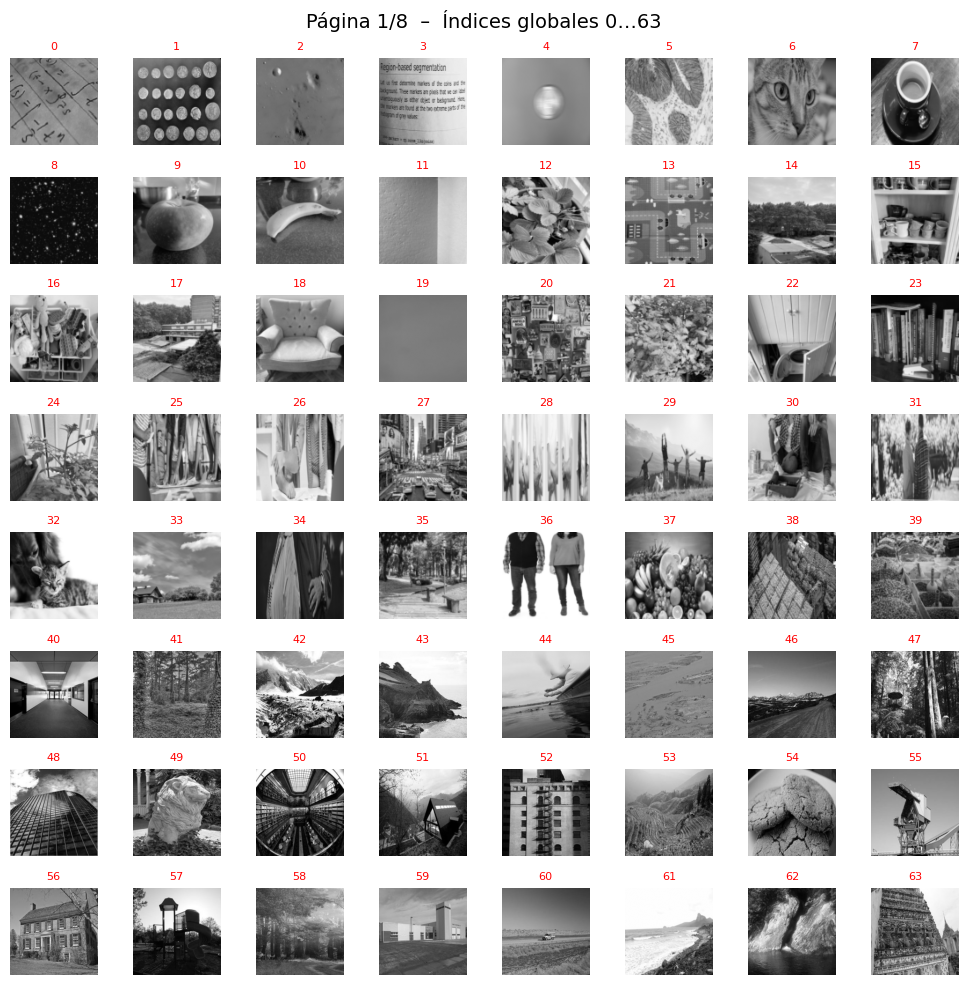

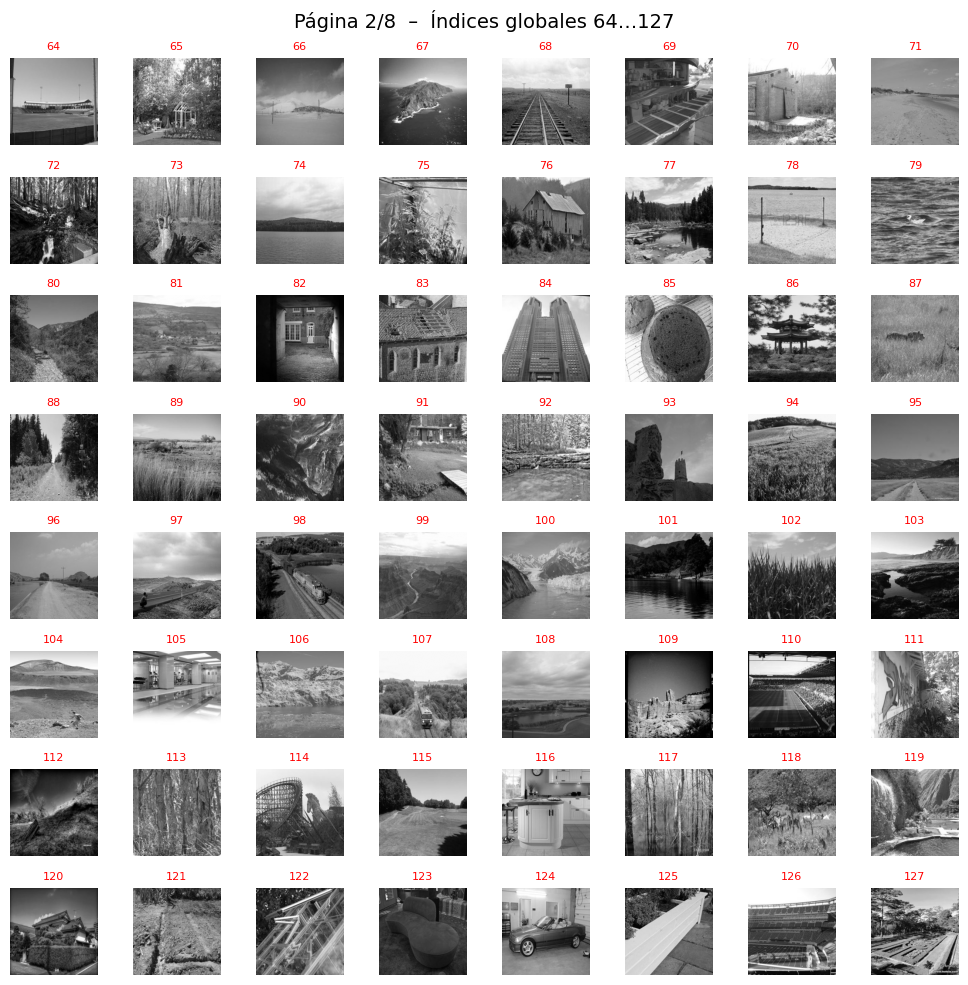

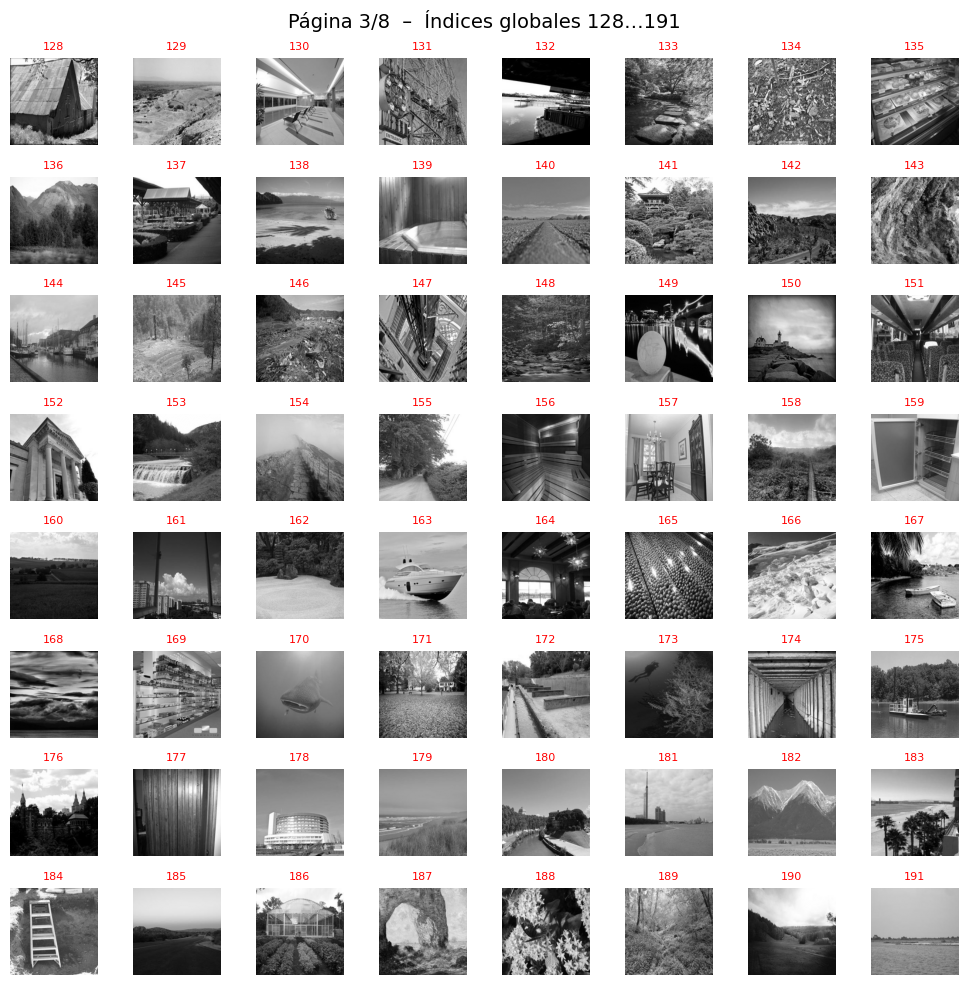

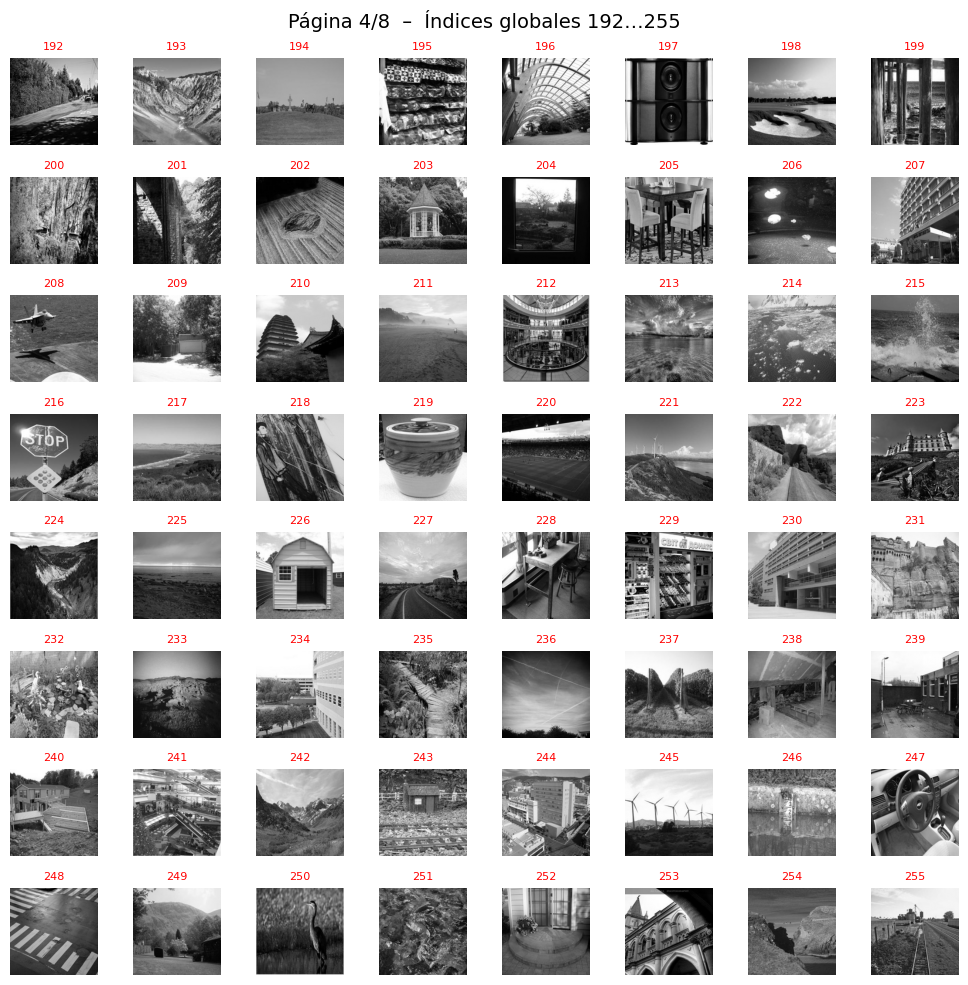

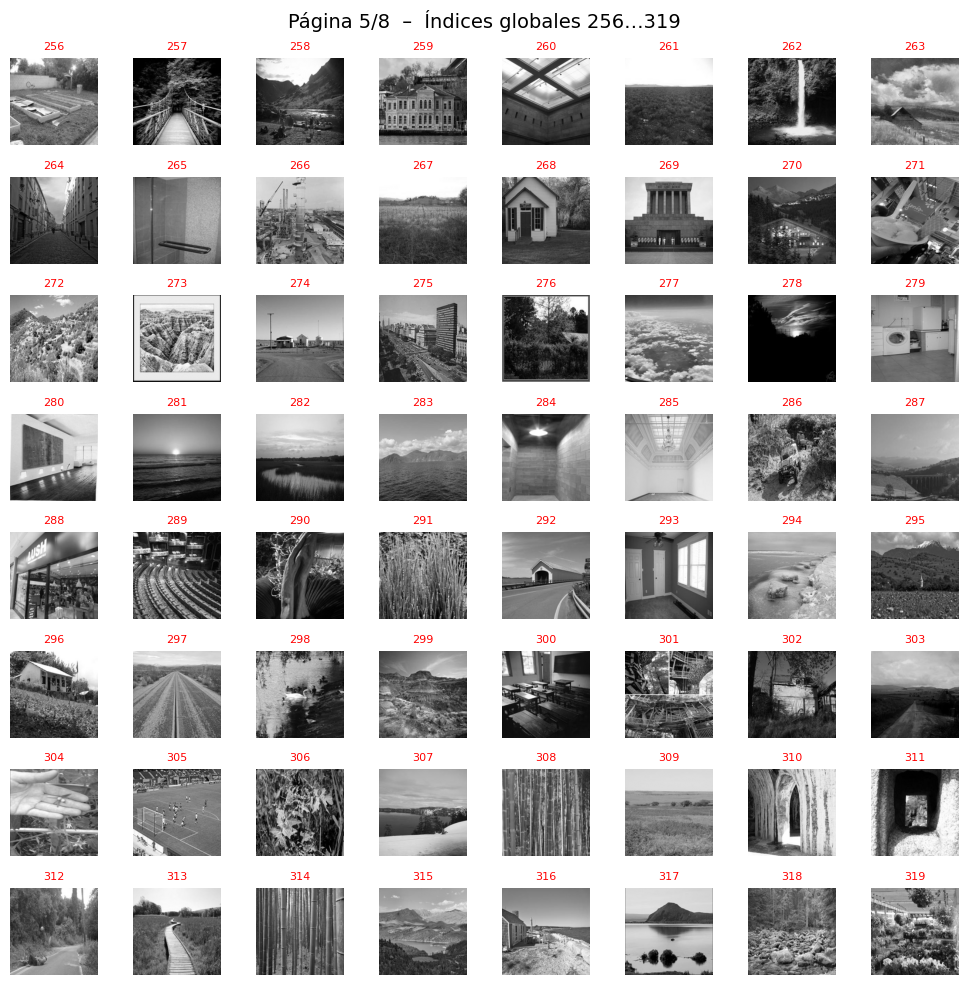

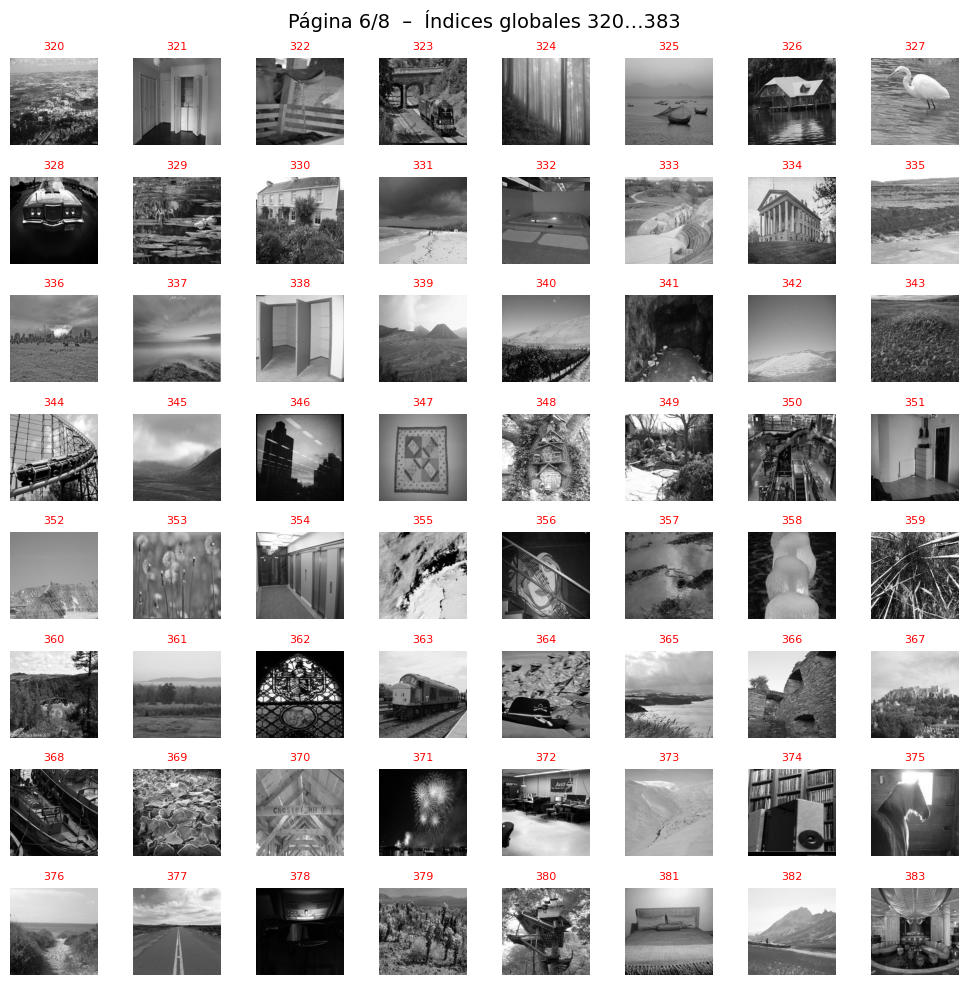

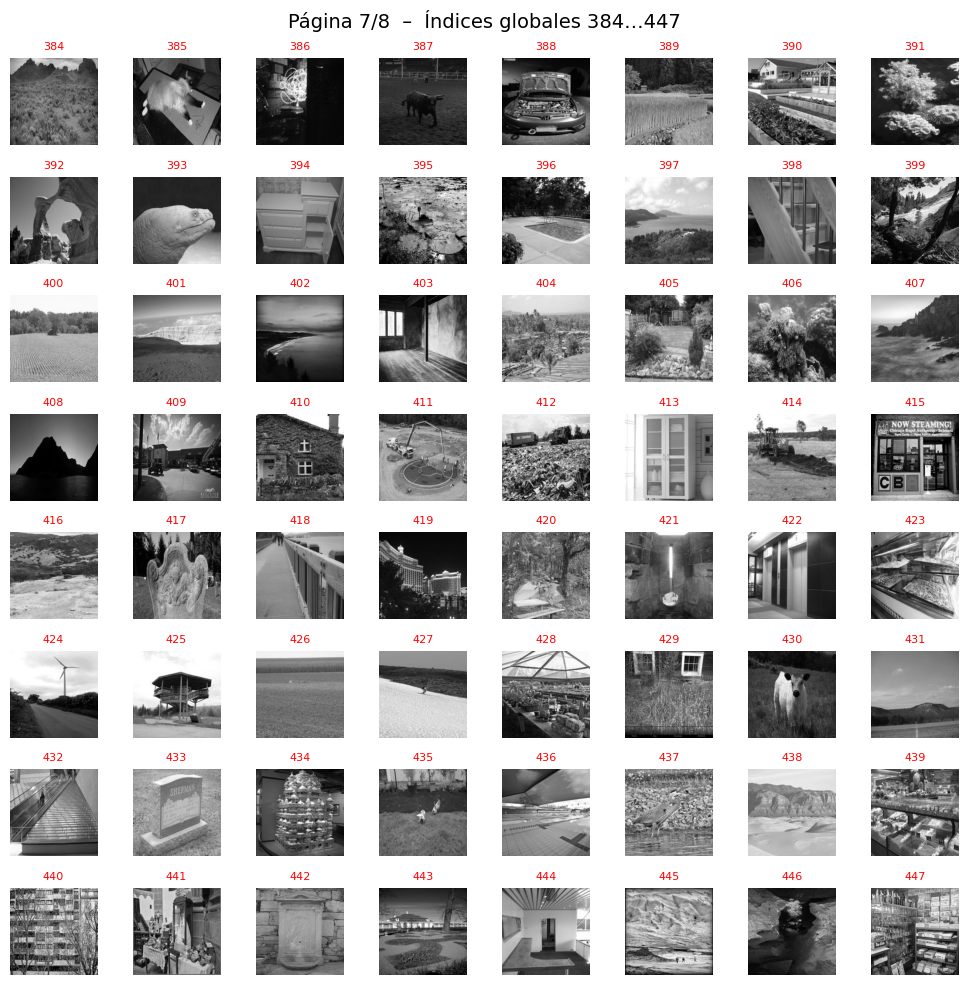

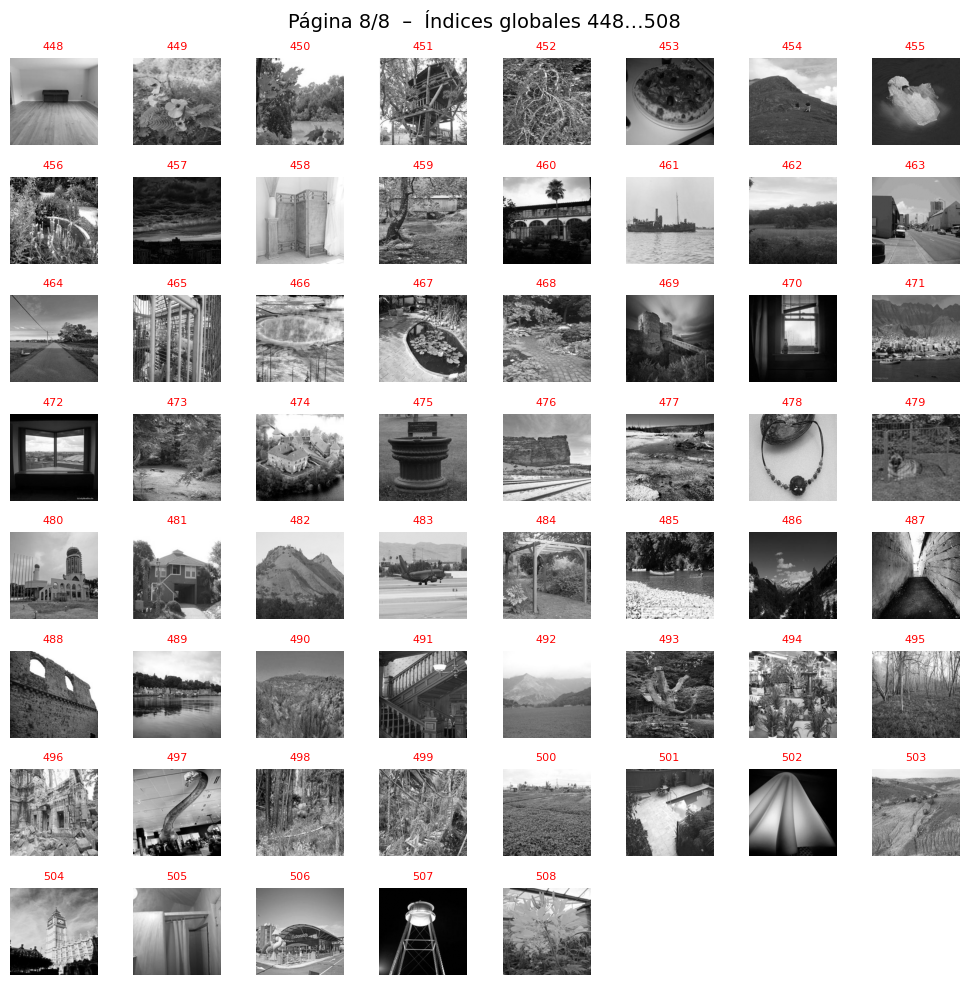


Total imágenes marcadas para eliminar: 3
Nuevo tamaño de `images`: 506


In [6]:
# -----------------------------------------------------------------------
# 📸 Revisión manual y eliminación de escenas con personas
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

# Asegurate de que `images` sea una lista de numpy arrays 2-D
# y que esté en rango [0,1].  (Si no, normalizalas antes).

page_size = 64          # 8 × 8
n_pages   = ceil(len(images) / page_size)

to_remove = set()       # índices a eliminar

for p in range(n_pages):
    start = p * page_size
    end   = min(len(images), start + page_size)
    batch = images[start:end]

    fig, axes = plt.subplots(8, 8, figsize=(10,10))
    fig.suptitle(f"Página {p+1}/{n_pages}  –  Índices globales {start}…{end-1}", fontsize=14)

    for i in range(64):
        ax = axes.flat[i]
        ax.axis("off")
        idx = start + i
        if idx < end:
            ax.imshow(batch[i], cmap='gray', vmin=0, vmax=1)
            ax.set_title(str(idx), fontsize=8, color='red')
    plt.tight_layout()
    plt.show()

    rm_input = input("Índices a eliminar en esta página (separados por coma, dejar vacío para ninguno): ")
    if rm_input.strip():
        bad = {int(s) for s in rm_input.split(",")}
        to_remove.update(bad)

print(f"\nTotal imágenes marcadas para eliminar: {len(to_remove)}")

# -----------------------------------------------------------------------
# 🚮  Quitamos las imágenes seleccionadas
# -----------------------------------------------------------------------
images = [im for i, im in enumerate(images) if i not in to_remove]

print(f"Nuevo tamaño de `images`: {len(images)}")


In [8]:
# Extraemos las imágenes de fondo de sklearn y las imágenes personalizadas
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando sklearn/custom') for scale in [0.25,0.5,0.75,1]])
#121923
print(f'{negative_patches.dtype=}, {negative_patches.min()=}, {negative_patches.max()=}')

print(f'Número de parches negativos: {len(negative_patches)}')

Procesando sklearn/custom: 100%|██████████| 506/506 [00:11<00:00, 42.73it/s]


negative_patches.dtype=dtype('uint8'), negative_patches.min()=0, negative_patches.max()=255
Número de parches negativos: 129536


In [ ]:
RATIO = 5
random.seed(42)
TOTAL_IMAGES = FACES_IMAGES * RATIO  # Número total de imágenes que queremos generar
if len(negative_patches) > TOTAL_IMAGES:
    negative_patches = random.sample(list(negative_patches), TOTAL_IMAGES)

negative_patches = np.array(negative_patches, dtype=np.uint8)

print(f'Número de parches negativos después de muestreo: {len(negative_patches)}')

print(f'{negative_patches.dtype=}, {negative_patches.min()=}, {negative_patches.max()=}')

Número de parches negativos después de muestreo: 12832
negative_patches.dtype=dtype('uint8'), negative_patches.min()=0, negative_patches.max()=255


In [14]:
def save_patches(patches, output_dir='../content', zip_filename = f'Backgrounds_reduced_x{RATIO}_v2.zip'):
    """
    Save patches as individual .pgm files compressed into a zip file.
    
    Args:
        patches (np.ndarray): Array of patches to save
        output_dir (str): Directory to save the .zip file
    """

    patches_folder_path = 'patches'
    prefix='background'

    # Create output directory if it doesn't exist
    os.makedirs(patches_folder_path, exist_ok=True)

    # If there's an existing zip file, remove it
    zip_filepath = os.path.join(output_dir, zip_filename)
    if os.path.exists(zip_filepath):
        os.remove(zip_filepath)
    
    saved_files = []
    for i, patch in enumerate(tqdm(patches, desc='Saving patches')):
        # Create filename
        filename = f"{prefix}_{i:06d}.pgm"
        file_path = os.path.join(patches_folder_path, filename)

        # Save as .pgm file using imageio
        imageio.imwrite(file_path, patch)

         # Add to list of saved files
        saved_files.append(file_path)
    
    print(f"Saving {len(patches)} patches as .pgm files...")
   
    # Create zip file with all the .pgm files
    zip_filepath = os.path.join(output_dir, zip_filename)

    print(f"\nCompressing {len(saved_files)} .pgm files into {zip_filename}...")
    with zipfile.ZipFile(zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in tqdm(saved_files, desc='Compressing files'):
            # Add file to zip with just the filename (not the full path)
            arcname = os.path.basename(file_path)
            zipf.write(file_path, arcname)
    
    print(f"\nZip file created: {zip_filepath}")
    
    print("Cleaning up temporary files...")
    for file_path in saved_files:
        os.remove(file_path)

save_patches(negative_patches)

Saving patches: 100%|██████████| 12832/12832 [00:04<00:00, 2643.29it/s]


Saving 12832 patches as .pgm files...

Compressing 12832 .pgm files into Backgrounds_reduced_x2_v2.zip...


Compressing files: 100%|██████████| 12832/12832 [00:02<00:00, 5225.64it/s]



Zip file created: ../content/Backgrounds_reduced_x2_v2.zip
Cleaning up temporary files...
